In [14]:
# import libraries
import pandas as pd
from scipy.stats import poisson, weibull_min, gamma
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
sys.path.append(os.path.dirname(os.getcwd()))
import db_tools as dbt
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson, chisquare
import weibull
from scipy import optimize
import csv

In [2]:
# Load the NOAA data into a DataFrame for analysis
df_noaa = dbt.query('SELECT * FROM "NOAA_STORM_EPISODES" ORDER BY county_fips, year')


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 107094 rows


In [16]:
df_noaa.to_csv(r'C:\noaa_storm_episodes.csv', index=False)

In [11]:
df_noaa.head()


,county_fips,year,event_count,total_deaths_direct,total_deaths_indirect,total_injuries_direct,total_injuries_indirect,event_types,first_event_date
0,01001,1999,1,0,0,2,0,Thunderstorm Wind,1999-03-03
1,01001,2000,2,0,0,2,0,Lightning,2000-04-02
2,01001,2001,0,0,0,0,0,,NaT
3,01001,2002,0,0,0,0,0,,NaT
4,01001,2003,1,0,0,3,0,Thunderstorm Wind,2003-04-25


In [13]:
print((df_noaa['event_count'] == 0).sum())

90845


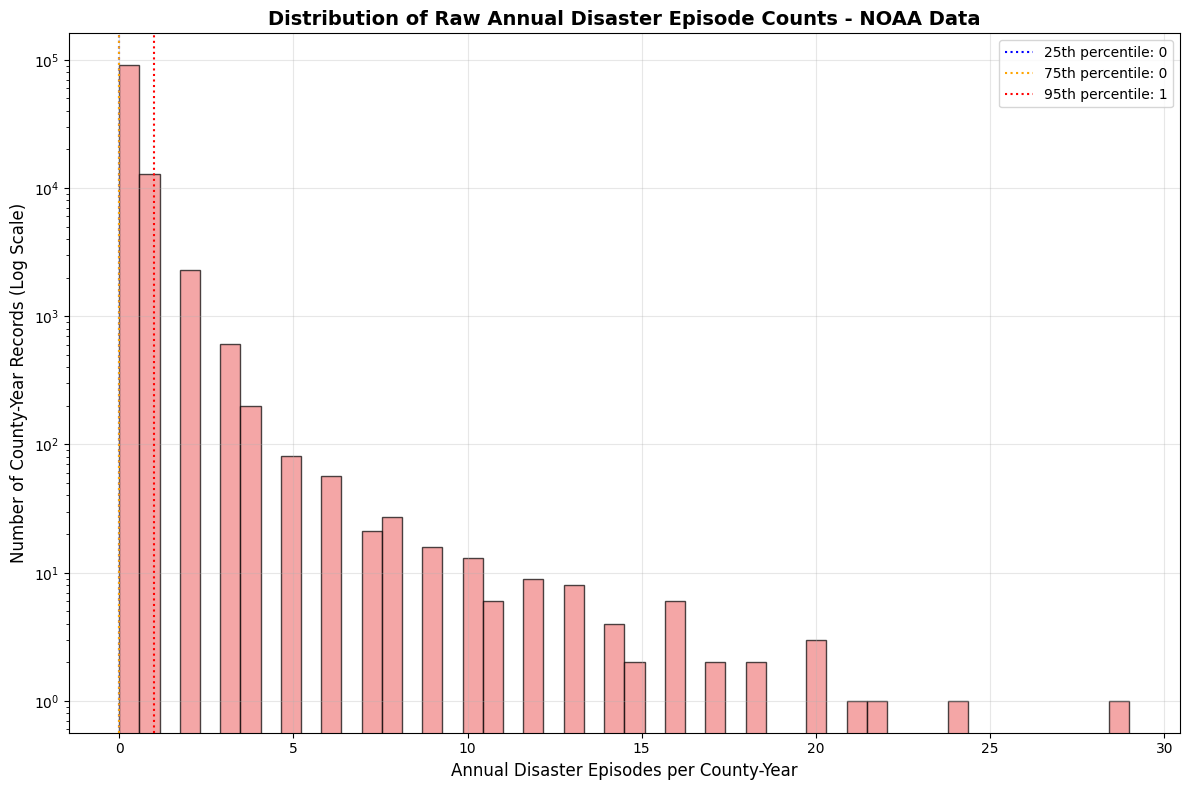

In [4]:
# Create histogram of raw event counts with log scale for distribution analysis
plt.figure(figsize=(12, 8))
plt.hist(
    df_noaa["event_count"], bins=50, alpha=0.7, edgecolor="black", color="lightcoral"
)
plt.xlabel("Annual Disaster Episodes per County-Year", fontsize=12)
plt.ylabel("Number of County-Year Records (Log Scale)", fontsize=12)
plt.title(
    "Distribution of Raw Annual Disaster Episode Counts - NOAA Data",
    fontsize=14,
    fontweight="bold",
)
plt.yscale("log")

# Add percentiles to help interpretation with log scale
raw_counts = df_noaa["event_count"]
p25_raw = raw_counts.quantile(0.25)
p75_raw = raw_counts.quantile(0.75)
p95_raw = raw_counts.quantile(0.95)

plt.axvline(
    p25_raw, color="blue", linestyle=":", label=f"25th percentile: {p25_raw:.0f}"
)
plt.axvline(
    p75_raw, color="orange", linestyle=":", label=f"75th percentile: {p75_raw:.0f}"
)
plt.axvline(
    p95_raw, color="red", linestyle=":", label=f"95th percentile: {p95_raw:.0f}"
)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:


counts = df_noaa["event_count"].to_numpy()
mean_c = counts.mean()
zero_c = (counts == 0).mean()
p_zip = (
    0
    if zero_c <= np.exp(-mean_c)
    else optimize.brentq(
        lambda p: p + (1 - p) * np.exp(-mean_c / (1 - p)) - zero_c, 1e-6, 0.999
    )
)
lam_zip = mean_c / (1 - p_zip)
support = np.arange(0, counts.max() + 1)
zip_probs = np.concatenate(
    (
        [p_zip + (1 - p_zip) * np.exp(-lam_zip)],
        (1 - p_zip) * poisson.pmf(support[1:], lam_zip),
    )
)
poi_probs = poisson.pmf(support, mean_c)
max_bin = min(len(support) - 1, 10)
obs = np.bincount(np.minimum(counts, max_bin), minlength=max_bin + 1)
exp_zip = (
    np.concatenate((zip_probs[:max_bin], [zip_probs[max_bin:].sum()])) * counts.size
)
exp_poi = (
    np.concatenate((poi_probs[:max_bin], [poi_probs[max_bin:].sum()])) * counts.size
)
zip_chi2 = chisquare(obs, exp_zip)
poi_chi2 = chisquare(obs, exp_poi)
pd.Series(
    {
        "lambda_poisson": mean_c,
        "lambda_zip": lam_zip,
        "p_zero_zip": p_zip,
        "obs_zero_rate": zero_c,
        "zip_zero_rate": zip_probs[0],
        "poi_zero_rate": poi_probs[0],
        "zip_chi2": zip_chi2.statistic,
        "zip_p": zip_chi2.pvalue,
        "poi_chi2": poi_chi2.statistic,
        "poi_p": poi_chi2.pvalue,
    }
).round(4)


lambda_poisson    2.069000e-01
lambda_zip        6.563000e-01
p_zero_zip        6.847000e-01
obs_zero_rate     8.483000e-01
zip_zero_rate     8.483000e-01
poi_zero_rate     8.131000e-01
zip_chi2          4.605479e+07
zip_p             0.000000e+00
poi_chi2          9.908415e+11
poi_p             0.000000e+00
dtype: float64

In [6]:
from scipy.special import gammaln

rows = []
for county, grp in df_noaa.groupby("county_fips"):
    arr = grp["event_count"].to_numpy()
    n = arr.size
    if n < 10:
        continue
    mean_c = arr.mean()
    if mean_c <= 0:
        continue
    zero_rate = (arr == 0).mean()
    p_zip = 0.0
    if zero_rate > np.exp(-mean_c):
        p_zip = optimize.brentq(lambda p: p + (1 - p) * np.exp(-mean_c / (1 - p)) - zero_rate, 1e-6, 0.999)
    lam_zip = mean_c / (1 - p_zip)
    lam_poi = mean_c
    tail = min(max(arr), 5)
    obs = np.bincount(np.minimum(arr, tail), minlength=tail + 1)
    zip_probs = np.concatenate(([p_zip + (1 - p_zip) * np.exp(-lam_zip)], (1 - p_zip) * poisson.pmf(np.arange(1, tail + 1), lam_zip)))
    poi_probs = poisson.pmf(np.arange(0, tail + 1), lam_poi)
    zip_probs[-1] += (1 - p_zip) * poisson.sf(tail, lam_zip)
    poi_probs[-1] += poisson.sf(tail, lam_poi)
    exp_zip = zip_probs * n
    exp_poi = poi_probs * n
    if (exp_zip <= 0).any() or (exp_poi <= 0).any():
        continue
    zip_chi2, zip_p = chisquare(obs, exp_zip)
    poi_chi2, poi_p = chisquare(obs, exp_poi)
    ll_poi = np.sum(arr * np.log(lam_poi) - lam_poi - gammaln(arr + 1))
    zeros = (arr == 0)
    ll_zip = zeros.sum() * np.log(zip_probs[0]) + np.sum(np.log((1 - p_zip) * poisson.pmf(arr[~zeros], lam_zip)))
    rows.append({
        "county_fips": county,
        "n": n,
        "mean": mean_c,
        "zero_rate": zero_rate,
        "p_zip": p_zip,
        "lambda_zip": lam_zip,
        "zip_chi2": zip_chi2,
        "zip_p": zip_p,
        "poi_chi2": poi_chi2,
        "poi_p": poi_p,
        "zip_aic": 2 * 2 - 2 * ll_zip,
        "poi_aic": 2 * 1 - 2 * ll_poi,
        "zip_bic": 2 * np.log(n) - 2 * ll_zip,
        "poi_bic": np.log(n) - 2 * ll_poi
    })

county_fit = pd.DataFrame(rows)
summary = pd.Series({
    "counties_tested": len(county_fit),
    "zip_better_chi2": (county_fit["zip_p"] > county_fit["poi_p"]).sum(),
    "zip_better_aic": (county_fit["zip_aic"] < county_fit["poi_aic"]).sum(),
    "zip_better_bic": (county_fit["zip_bic"] < county_fit["poi_bic"]).sum()
})
county_fit.head(), summary

(  county_fips   n      mean  zero_rate     p_zip  lambda_zip  zip_chi2  \
 0       01001  26  0.576923   0.500000  0.000000    0.576923  1.281948   
 1       01002  26  0.269231   0.769231  0.149753    0.316650  0.013099   
 2       01003  26  1.230769   0.346154  0.141383    1.433433  2.269255   
 3       01004  26  0.076923   0.923077  0.000000    0.076923  0.003155   
 4       01005  26  0.307692   0.769231  0.492140    0.605860  0.111899   
 
       zip_p  poi_chi2     poi_p    zip_aic    poi_aic    zip_bic    poi_bic  
 0  0.526779  1.281948  0.526779  53.273979  51.273979  55.790172  52.532075  
 1  0.993472  0.079930  0.960823  37.726818  35.756904  40.243011  37.015000  
 2  0.810772  4.160309  0.526574  81.227520  79.968093  83.743713  81.226189  
 3  0.955209  0.003155  0.955209  18.259797  16.259797  20.775991  17.517894  
 4  0.945587  1.627334  0.443230  40.685765  39.631069  43.201958  40.889165  ,
 counties_tested    4119
 zip_better_chi2    1146
 zip_better_aic      46

In [7]:
from scipy.special import gammaln

rows = []
for county, grp in df_noaa.groupby("county_fips"):
    arr = grp["event_count"].to_numpy()
    n = arr.size
    if n < 10:
        continue

    mean_c = arr.mean()
    if mean_c <= 0:
        continue

    zero_rate = (arr == 0).mean()
    p_zip = 0.0
    if zero_rate > np.exp(-mean_c):
        p_zip = optimize.brentq(
            lambda p: p + (1 - p) * np.exp(-mean_c / (1 - p)) - zero_rate,
            1e-6,
            0.999,
        )

    lam_poi = mean_c
    lam_zip = mean_c / (1 - p_zip)

    tail = min(int(arr.max()), 5)
    obs = np.bincount(np.minimum(arr, tail), minlength=tail + 1)

    poi_probs = poisson.pmf(np.arange(tail + 1), lam_poi)
    zip_probs = np.concatenate(
        (
            [p_zip + (1 - p_zip) * np.exp(-lam_zip)],
            (1 - p_zip) * poisson.pmf(np.arange(1, tail + 1), lam_zip),
        )
    )
    poi_probs[-1] += poisson.sf(tail, lam_poi)
    zip_probs[-1] += (1 - p_zip) * poisson.sf(tail, lam_zip)

    exp_poi = poi_probs * n
    exp_zip = zip_probs * n
    if (exp_poi <= 0).any() or (exp_zip <= 0).any():
        continue

    zip_chi2, zip_p = chisquare(obs, exp_zip)
    poi_chi2, poi_p = chisquare(obs, exp_poi)

    ll_poi = np.sum(arr * np.log(lam_poi) - lam_poi - gammaln(arr + 1))
    zeros = arr == 0
    ll_zip = (
        zeros.sum() * np.log(zip_probs[0])
        + np.sum(np.log((1 - p_zip) * poisson.pmf(arr[~zeros], lam_zip)))
    )

    rows.append(
        {
            "county_fips": county,
            "n": n,
            "mean": mean_c,
            "zero_rate": zero_rate,
            "p_zip": p_zip,
            "lambda_zip": lam_zip,
            "zip_chi2": zip_chi2,
            "zip_p": zip_p,
            "poi_chi2": poi_chi2,
            "poi_p": poi_p,
            "ll_zip": ll_zip,
            "ll_poi": ll_poi,
        }
    )

county_fit = pd.DataFrame(rows)
county_fit["zip_aic"] = 2 * 2 - 2 * county_fit["ll_zip"]
county_fit["poi_aic"] = 2 * 1 - 2 * county_fit["ll_poi"]
county_fit["zip_bic"] = 2 * np.log(county_fit["n"]) - 2 * county_fit["ll_zip"]
county_fit["poi_bic"] = np.log(county_fit["n"]) - 2 * county_fit["ll_poi"]

county_fit.head()

,county_fips,n,mean,zero_rate,p_zip,lambda_zip,zip_chi2,zip_p,poi_chi2,poi_p,ll_zip,ll_poi,zip_aic,poi_aic,zip_bic,poi_bic
0,01001,26,0.576923,0.500000,0.000000,0.576923,1.281948,0.526779,1.281948,0.526779,-24.636989,-24.636989,53.273979,51.273979,55.790172,52.532075
1,01002,26,0.269231,0.769231,0.149753,0.316650,0.013099,0.993472,0.079930,0.960823,-16.863409,-16.878452,37.726818,35.756904,40.243011,37.015000
2,01003,26,1.230769,0.346154,0.141383,1.433433,2.269255,0.810772,4.160309,0.526574,-38.613760,-38.984046,81.227520,79.968093,83.743713,81.226189
3,01004,26,0.076923,0.923077,0.000000,0.076923,0.003155,0.955209,0.003155,0.955209,-7.129899,-7.129899,18.259797,16.259797,20.775991,17.517894
4,01005,26,0.307692,0.769231,0.492140,0.605860,0.111899,0.945587,1.627334,0.443230,-18.342882,-18.815534,40.685765,39.631069,43.201958,40.889165


In [8]:
from scipy.stats import norm

county_fit["lr_stat"] = np.maximum(0, 2 * (county_fit["ll_zip"] - county_fit["ll_poi"]))
county_fit["zip_lr_p"] = 0.5 * (1 - norm.cdf(np.sqrt(county_fit["lr_stat"])))
county_fit["zip_lr_sig"] = county_fit["zip_lr_p"] < 0.05

summary = pd.Series(
    {
        "counties_tested": len(county_fit),
        "zip_better_chi2": (county_fit["zip_p"] > county_fit["poi_p"]).sum(),
        "zip_better_aic": (county_fit["zip_aic"] < county_fit["poi_aic"]).sum(),
        "zip_better_bic": (county_fit["zip_bic"] < county_fit["poi_bic"]).sum(),
        "zip_lr_sig": county_fit["zip_lr_sig"].sum(),
    }
)
summary

counties_tested    4119
zip_better_chi2    1146
zip_better_aic      467
zip_better_bic      279
zip_lr_sig          521
dtype: int64